In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys
sys.path.append("../src")

from vidtoseg import r2plus1d, parallel2dconv, simsiam, unet
from data import LabeledDataset, unnormalize
from torchmetrics import JaccardIndex

import torch

In [3]:
dataset = LabeledDataset("../Dataset_Student")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

In [4]:
vid, masks = next(iter(dataloader))

x1 = vid[:,:11].transpose(1, 2)
x2 = vid[:,11:].transpose(1, 2)

print(x1.shape)

torch.Size([2, 3, 11, 160, 240])


In [4]:
backbone = r2plus1d.R2Plus1DNet()
output = backbone(x)

print(output.shape)
print(sum(p.numel() for p in backbone.parameters() if p.requires_grad))
del backbone

torch.Size([2, 256, 2, 16, 16])
13023527


Sizes of each layer output
```
torch.Size([1, 3, 11, 256, 256])
torch.Size([1, 32, 11, 128, 128])
torch.Size([1, 32, 11, 128, 128])
torch.Size([1, 64, 6, 64, 64])
torch.Size([1, 128, 3, 32, 32])
torch.Size([1, 256, 2, 16, 16])
```

In [13]:


backbone = parallel2dconv.Parallel2DResNet()
output = backbone(x)

print(output.shape)
print(sum(p.numel() for p in backbone.parameters() if p.requires_grad))
del backbone

NameError: name 'x' is not defined

In [16]:
ssl_model = simsiam.SimSiamGSTA(parallel2dconv.Parallel2DResNet, num_channels_backbone=256 * 11)
print(sum(p.numel() for p in ssl_model.parameters() if p.requires_grad))

p1, p2, h1, h2 = ssl_model(x1, x2)

del ssl_model

300435776


NameError: name 'x1' is not defined

In [32]:
model = unet.UNetVidToSeg(parallel2dconv.Parallel2DResNet())
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
res = model(x1)

print(res.shape)
del model

5381073
torch.Size([2, 49, 11, 160, 240])


In [33]:
print(res.shape)

torch.Size([2, 49, 11, 160, 240])


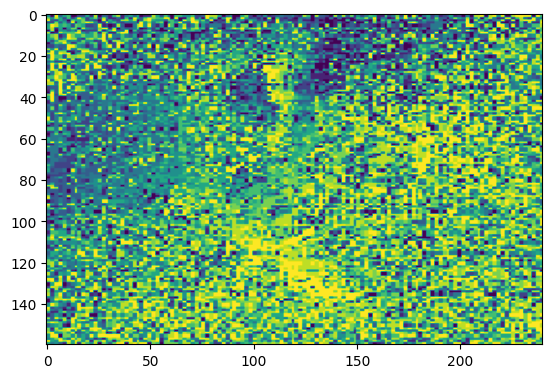

In [42]:
import matplotlib.pyplot as plt

plt.imshow(torch.argmax(res[0][3], dim=0))

In [48]:
iou = JaccardIndex(task="multiclass", num_classes=49)

target = masks[:,11:]
print(target.shape)
print(res.shape)

print(iou(res, target))

torch.Size([2, 11, 160, 240])
torch.Size([2, 49, 11, 160, 240])
tensor(0.0007)


In [50]:
masks[:,(2, 4)].shape

torch.Size([2, 2, 160, 240])

In [28]:
from simvp.modules import Decoder
from simvp.simvp import SimVP_Model

model = SimVP_Model(in_shape=(11,3,160,240), hid_S=64, hid_T=256, N_T=8, N_S=4, drop_path=0.1)
model.out_shape = (1, 3, 160, 240)
model.dec = Decoder(11 * model.hid_S, 3, 4, 3)


In [29]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


64618883


In [26]:
x = x1.transpose(1, 2)
x.shape

torch.Size([2, 11, 3, 160, 240])

In [27]:
model(x).shape

torch.Size([2, 1, 3, 160, 240])